# Trexquant Interview Project (The Hangman Game)

* Copyright Trexquant Investment LP. All Rights Reserved. 
* Redistribution of this question without written consent from Trexquant is prohibited

## Instruction:
For this coding test, your mission is to write an algorithm that plays the game of Hangman through our API server. 

When a user plays Hangman, the server first selects a secret word at random from a list. The server then returns a row of underscores (space separated)—one for each letter in the secret word—and asks the user to guess a letter. If the user guesses a letter that is in the word, the word is redisplayed with all instances of that letter shown in the correct positions, along with any letters correctly guessed on previous turns. If the letter does not appear in the word, the user is charged with an incorrect guess. The user keeps guessing letters until either (1) the user has correctly guessed all the letters in the word
or (2) the user has made six incorrect guesses.

You are required to write a "guess" function that takes current word (with underscores) as input and returns a guess letter. You will use the API codes below to play 1,000 Hangman games. You have the opportunity to practice before you want to start recording your game results.

Your algorithm is permitted to use a training set of approximately 250,000 dictionary words. Your algorithm will be tested on an entirely disjoint set of 250,000 dictionary words. Please note that this means the words that you will ultimately be tested on do NOT appear in the dictionary that you are given. You are not permitted to use any dictionary other than the training dictionary we provided. This requirement will be strictly enforced by code review.

You are provided with a basic, working algorithm. This algorithm will match the provided masked string (e.g. a _ _ l e) to all possible words in the dictionary, tabulate the frequency of letters appearing in these possible words, and then guess the letter with the highest frequency of appearence that has not already been guessed. If there are no remaining words that match then it will default back to the character frequency distribution of the entire dictionary.

This benchmark strategy is successful approximately 18% of the time. Your task is to design an algorithm that significantly outperforms this benchmark.

In [1]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections

try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

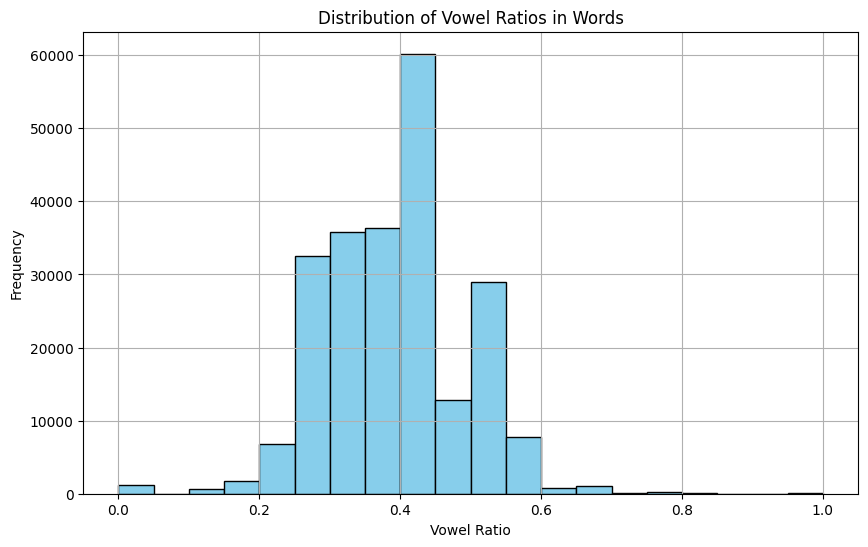

count    227300.000000
mean          0.386887
std           0.095519
min           0.000000
25%           0.333333
50%           0.384615
75%           0.444444
max           1.000000
dtype: float64


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate vowel to word length ratio
def vowel_count(clean_word):
    vowels = ['a', 'e', 'i', 'o', 'u']
    return sum(1 for char in clean_word if char in vowels) / len(clean_word)

# Loading and cleaning data
with open("words_250000_train.txt", "r") as file:
    df = [line.strip() for line in file]

# Calculating ratios
ratios = pd.Series([vowel_count(word) for word in df])

# Describing the distribution
description = ratios.describe()

# Plotting the histogram of vowel ratios
plt.figure(figsize=(10, 6))
bins = np.arange(0, 1.05, 0.05)  # Define bins from 0 to 1 with a step of 0.05
plt.hist(ratios, bins=bins, color='skyblue', edgecolor='black')
plt.title('Distribution of Vowel Ratios in Words')
plt.xlabel('Vowel Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Printing the description
print(description)


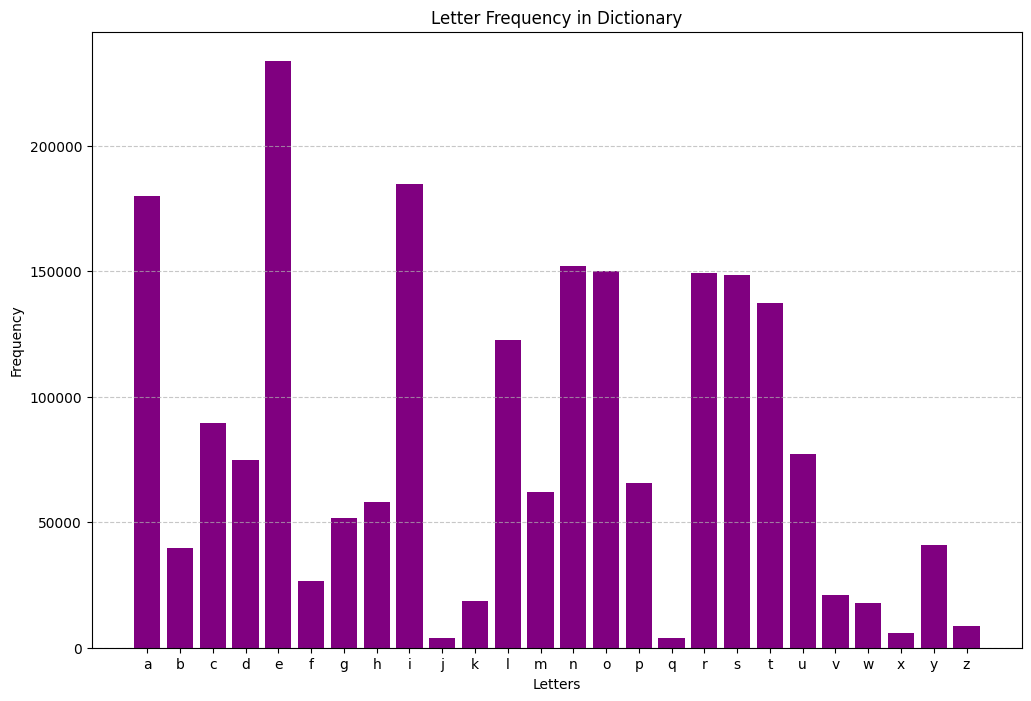

In [3]:
import matplotlib.pyplot as plt
from collections import Counter

# Function to count the frequency of each letter in the dictionary
def letter_frequency(words):
    return Counter(letter for word in words for letter in word.lower() if letter.isalpha())

# Loading and clean data
with open("words_250000_train.txt", "r") as file:
    words = [line.strip().lower() for line in file]

# Getting letter frequency
freq = letter_frequency(words)

# Preparing data for plotting
labels, values = zip(*sorted(freq.items()))

# Creating the bar chart
plt.figure(figsize=(12, 8))
plt.bar(labels, values, color='purple')
plt.title('Letter Frequency in Dictionary')
plt.xlabel('Letters')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [4]:
class HangmanAPI(object):
    def __init__(self, access_token=None, session=None, timeout=None):
        # Initializing the Hangman API URL by determining the fastest available server.
        self.hangman_url = self.determine_hangman_url()
        # Setting the access token, initializing the HTTP session, and setting the timeout for API calls.
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []
        
        # Loading a list of words from a specified text file, initializing the dictionary for gameplay.
        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)        
        # Counting and sorting letters by frequency across the entire dictionary, setting up a common letter frequency list.
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()
        
        # Initializing lists for storing frequency data of n-grams, prefixes, and suffixes.
        self.current_dictionary = []
        self.nseq_freq_list = []
        self.prefix_freq_list = []
        self.suffix_freq_list = []

        # Nested function to create frequency dictionaries for n-grams, prefixes, and suffixes.
        def create_freq(dictionary, n):
            suf_freq = {}
            n_seq_freq = {}
            pre_freq = {}
            
            # Iterating through each word in the dictionary, computing the frequency of each sequence.
            for words in dictionary:
                if (len(words) < n):
                    continue
                    
                # Processing each n-gram in the word, setting frequencies for general sequences.
                for i in range(len(words)-n+1):
                    n_seq_freq[words[i:i+n]] = n_seq_freq.get(words[i:i+n], 0) + 1
            
                # Computing the frequency of the prefix.
                pre_freq[words[:n]] = pre_freq.get(words[:n], 0) + 1
                # Computing the frequency of the suffix.
                suf_freq[words[-n:]] = suf_freq.get(words[-n:], 0) + 1
                
            return n_seq_freq, pre_freq, suf_freq
        
        # Computing frequencies for all lengths up to max_sequence_length, initializing frequency lists.
        self.max_sequence_length = 7
        for i in range(self.max_sequence_length):
            temp1, temp2, temp3 = create_freq(self.full_dictionary, i+1)
            self.nseq_freq_list.append(temp1)
            self.prefix_freq_list.append(temp2)
            self.suffix_freq_list.append(temp3)  

    @staticmethod
    def determine_hangman_url():
        # Testing multiple URLs for response time and selecting the fastest, setting the base URL for the game.
        links = ['https://trexsim.com', 'https://sg.trexsim.com']
        data = {link: 0 for link in links}
        for link in links:
            for i in range(10):
                s = time.time()
                requests.get(link)
                data[link] += time.time() - s
        link = sorted(data.items(), key=lambda x: x[1])[0][0]
        link += '/trexsim/hangman'
        return link

    def guess(self, word): 
        # Extracting clean_word from the masked word example "_ p p _ e " by removing spaces and replacing underscores with dots.
        clean_word = word[::2].replace("_",".")
        max_sequence_length = self.max_sequence_length
        
        # Creating a set of letters that have been guessed but are not in the answer.
        guessed_but_not_found_letters = set()
        for let in self.guessed_letters:
            if let not in clean_word:
                guessed_but_not_found_letters.add(let)
        
        # Determining the length of the cleaned word.
        len_word = len(clean_word)        
        
        # Calculating the percentage of blanks in the cleaned word.
        blanks_pct = clean_word.count('.') / len_word
        vowels = "aeiou"
        # Counting the number of vowels in the cleaned word.
        num_vowels = sum(1 for char in clean_word if char in vowels)
        # Calculating the number of consonants in the cleaned word.
        num_consonants = len(clean_word) - num_vowels
        # Calculating the ratio of vowels to consonants in the cleaned word.
        vowel_consonant_ratio = num_vowels / num_consonants if num_consonants != 0 else float('inf')
        
        # Retrieving the current dictionary of possible words and initializing an empty list for new possible words.
        current_dictionary = self.current_dictionary
        new_dictionary = []
                    
        # Iterating through each word in the current dictionary.
        for dict_word in current_dictionary:
            # Continuing only if the word is of the appropriate length.
            if len(dict_word) != len_word:
                continue
            else: 
                # Considering adding the dictionary word to the new dictionary if it matches the cleaned word.
                if re.match(clean_word, dict_word):
                    add = True

                    # Checking if the dictionary word contains any of the guessed but not found letters.
                    for char in guessed_but_not_found_letters:
                        if char in dict_word:
                            add = False
                            break
                    
                    # Adding the word to the new dictionary if it does not contain any incorrect letters.
                    if add:
                        new_dictionary.append(dict_word)
                        
        # Updating the current dictionary with the new dictionary.
        self.current_dictionary = new_dictionary
        
        # If a large portion of the word is still unknown, using the most common letters from the potential words.
        if blanks_pct >= 0.70 and len(new_dictionary) != 0:
            freq_table_init = collections.Counter("".join(self.current_dictionary)).most_common() 
            for letter, freq in freq_table_init:
                if letter not in self.guessed_letters:
                    return letter
        else:
            # Initializing a frequency table for letters based on advanced analysis.
            freq_table_lat = {alphabet: 0 for alphabet in string.ascii_lowercase}
            
            # Weighting factors for different lengths of n-grams, prefixes, and suffixes.
            n_seq_weights  = [1, 10, 100, 1000, 10000, 100000, 1000000]
            prefix_weights = [1, 10, 100, 1000, 10000, 100000, 1000000]
            suffix_weights = [1, 10, 100, 1000, 10000, 100000, 1000000]

            # Analyzing n-grams, prefixes, and suffixes from the frequency lists and adjusting letter frequencies accordingly.
            for i in range(max_sequence_length):
                # Analyzing n-grams.
                temp = self.nseq_freq_list[i]
                for ngram, freq in sorted(temp.items(), key=lambda x: (x[1], x[0]), reverse=True):
                    curr = list(ngram)
                    guess_letters = []
                    skip = False
                    for pos in range(i+1):
                        if curr[pos] in guessed_but_not_found_letters:
                            skip = True
                            break
                        elif curr[pos] not in self.guessed_letters:
                            guess_letters.append(curr[pos])
                            curr[pos] = '!'
                    
                    temp_string = clean_word.replace('.', '!')
                    curr = "".join(curr)
                    if not skip and guess_letters:
                        if re.search(curr, temp_string):
                            for match in re.finditer(curr, temp_string):
                                for guess in guess_letters:
                                    freq_table_lat[guess] += (n_seq_weights[i] * freq)
                            break
                
                # Repeating similar analysis for prefixes and suffixes.
                # Each block checks for match, avoids incorrect letters, and updates frequencies based on weights and actual frequencies of sequences in potential words.
                
            # Adjusting letter frequencies based on the vowel-to-consonant ratio, prioritizing vowels or consonants as needed.
            if vowel_consonant_ratio > 1.5:
                for vowel in vowels:
                    if vowel not in self.guessed_letters:
                        freq_table_lat[vowel] *= 0.1
            
            # Choosing the letter with the highest computed frequency that has not been guessed yet.
            for letter, _ in sorted(freq_table_lat.items(), key=lambda x: (x[1], x[0]), reverse=True):
                if letter not in self.guessed_letters:
                    return letter
        
        # As a fallback, returning the most common letter from the full dictionary that has not yet been guessed.
        for letter, _ in self.full_dictionary_common_letter_sorted:
            if letter not in self.guessed_letters:
                return letter

    ##########################################################
    # You'll likely not need to modify any of the code below #
    ##########################################################
    
    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary
                
    def start_game(self, practice=True, verbose=True):
        # reseting guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary
                         
        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # getting guessed letter from user code
                guess_letter = self.guess(word)
                    
                # appending guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))
                    
                try:    
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e
               
                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"
        
    def my_status(self):
        return self.request("/my_status", {})
    
    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Adding `access_token` to post_args or args if it has not already been
        # included.
        if self.access_token:
            # If post_args exists, we assume that args either does not exists
            # or it does not need `access_token`.
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        time.sleep(0.2)

        num_retry, time_sleep = 50, 2
        for it in range(num_retry):
            try:
                response = self.session.request(
                    method or "GET",
                    self.hangman_url + path,
                    timeout=self.timeout,
                    params=args,
                    data=post_args,
                    verify=False
                )
                break
            except requests.HTTPError as e:
                response = json.loads(e.read())
                raise HangmanAPIError(response)
            except requests.exceptions.SSLError as e:
                if it + 1 == num_retry:
                    raise
                time.sleep(time_sleep)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result
    
class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message)


# API Usage Examples

## To start a new game:
1. Make sure you have implemented your own "guess" method.
2. Use the access_token that we sent you to create your HangmanAPI object. 
3. Start a game by calling "start_game" method.
4. If you wish to test your function without being recorded, set "practice" parameter to 1.
5. Note: You have a rate limit of 20 new games per minute. DO NOT start more than 20 new games within one minute.

In [5]:
api = HangmanAPI(access_token="18552f6f71dc9d6fe11b363403db1a", timeout=2000)


## Playing practice games:
You can use the command below to play up to 100,000 practice games.

In [6]:
api.start_game(practice=1,verbose=True)
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
practice_success_rate = total_practice_successes / total_practice_runs
print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))

Successfully start a new game! Game ID: f8210d02cf74. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ .
Guessing letter: e
Sever response: {'game_id': 'f8210d02cf74', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ e _ _ _ _ _ _ '}
Guessing letter: n
Sever response: {'game_id': 'f8210d02cf74', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ e n _ _ _ _ _ '}
Guessing letter: s
Sever response: {'game_id': 'f8210d02cf74', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ s _ _ e n _ _ _ _ _ '}
Guessing letter: i
Sever response: {'game_id': 'f8210d02cf74', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ s _ i e n _ i _ i _ '}
Guessing letter: t
Sever response: {'game_id': 'f8210d02cf74', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ s _ i e n t i _ i _ '}
Guessing letter: c
Sever response: {'game_id': 'f8210d02cf74', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ s c i e n t i _ i c '}
Guessing letter: f
Sever response: 

In [7]:
# Assuming the provided code is part of a larger script or function

# Setting the target practice success rate
target_success_rate = 0.70

# Continuing the loop until the practice success rate reaches the target
while practice_success_rate < target_success_rate and total_practice_runs < 180:
    # Starting a new game
    api.start_game(practice=1, verbose=True)

    # Getting updated game stats
    [total_practice_runs, total_recorded_runs, total_recorded_successes, total_practice_successes] = api.my_status()

    # Calculating the practice success rate
    practice_success_rate = total_practice_successes / total_practice_runs

    # Printing the current status
    print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))

# Printing a message when the loop exits
if practice_success_rate >= target_success_rate:
    print("Achieved the target practice success rate of %.3f!" % target_success_rate)
else:
    print("Exceeded the maximum allowed practice games (180) without reaching the target success rate.")

Successfully start a new game! Game ID: 30a2b66c68b7. # of tries remaining: 6. Word: _ _ _ _ _ _ _ .
Guessing letter: e
Sever response: {'game_id': '30a2b66c68b7', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ '}
Guessing letter: a
Sever response: {'game_id': '30a2b66c68b7', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ _ '}
Guessing letter: o
Sever response: {'game_id': '30a2b66c68b7', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ o _ _ _ '}
Guessing letter: i
Sever response: {'game_id': '30a2b66c68b7', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ o i _ _ '}
Guessing letter: n
Sever response: {'game_id': '30a2b66c68b7', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ o i _ _ '}
Guessing letter: s
Sever response: {'game_id': '30a2b66c68b7', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ o i s _ '}
Guessing letter: l
Sever response: {'game_id': '30a2b66c68b7', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ l 

## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.

In [8]:
for i in range(1, 101):
    print(f'Playing game {i}')
    api.start_game(practice=0, verbose=False)
    time.sleep(0.5)


Playing game 1
Playing game 2
Playing game 3
Playing game 4
Playing game 5
Playing game 6
Playing game 7
Playing game 8
Playing game 9
Playing game 10
Playing game 11
Playing game 12
Playing game 13
Playing game 14
Playing game 15
Playing game 16
Playing game 17
Playing game 18
Playing game 19
Playing game 20
Playing game 21
Playing game 22
Playing game 23
Playing game 24
Playing game 25
Playing game 26
Playing game 27
Playing game 28
Playing game 29
Playing game 30
Playing game 31
Playing game 32
Playing game 33
Playing game 34
Playing game 35
Playing game 36
Playing game 37
Playing game 38
Playing game 39
Playing game 40
Playing game 41
Playing game 42
Playing game 43
Playing game 44
Playing game 45
Playing game 46
Playing game 47
Playing game 48
Playing game 49
Playing game 50
Playing game 51
Playing game 52
Playing game 53
Playing game 54
Playing game 55
Playing game 56
Playing game 57
Playing game 58
Playing game 59
Playing game 60
Playing game 61
Playing game 62
Playing game 63
P

HangmanAPIError: {'error': 'You have reached 1000 of games', 'status': 'denied'}

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [9]:
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
success_rate = total_recorded_successes/total_recorded_runs
print('overall success rate = %.3f' % success_rate)
total_recorded_runs

overall success rate = 0.603


1000